In [1]:
# Cell 1: Setup and root detect
# %matplotlib inline
"""Enhanced config: robust project root detection, explicit DATA_ROOT override, verification, tree printing."""

from __future__ import annotations
import os, math, random, hashlib
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns

# tqdm fallback
try:
    from tqdm import tqdm
except ImportError:  # Safe fallback if tqdm not installed
    class tqdm:  # type: ignore
        def __init__(self, it, **kwargs): self.it = it
        def __iter__(self):
            for x in self.it: yield x
        def update(self, *_): pass
        def close(self): pass

# -----------------
# Robust Project Root Detection
# -----------------
def find_project_root(start: Path = Path.cwd(), marker: str = 'data') -> Path:
    """Ascend until a directory containing the marker (e.g., 'data') is found.
    Falls back to parent if notebook is inside notebooks/ subdir."""
    visited = []
    current = start.resolve()
    for _ in range(8):  # up to 8 levels
        visited.append(str(current))
        if (current / marker).exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    # Fallback: if we started inside a notebooks folder, try its parent explicitly
    if start.name == 'notebooks' and (start.parent / marker).exists():
        return start.parent
    return start  # last resort

raw_cwd = Path.cwd().resolve()
PROJECT_ROOT = find_project_root(raw_cwd)
print(f"Detected working directory: {raw_cwd}")
print(f"Resolved project root:      {PROJECT_ROOT}")
print(f"Project root contains 'data': {(PROJECT_ROOT / 'data').exists()}")

# -----------------
# Configuration
# -----------------
DATA_ROOT = PROJECT_ROOT / 'data' / 'external' / 'kaggle_pneumonia' / 'chest_xray'
EXPECTED_SPLITS: List[str] = ['train', 'val', 'test']
EXPECTED_CLASSES: List[str] = ['NORMAL', 'PNEUMONIA']
FILE_EXTENSIONS = {'.jpeg', '.jpg', '.png'}
RANDOM_SEED = 42
HIST_SAMPLE_SIZE = 200
IMBALANCE_THRESHOLD = 0.4
ASPECT_ZSCORE_THRESHOLD = 3.0
FILESIZE_ZSCORE_THRESHOLD = 3.0
ENABLE_TQDM = True
OUTPUT_META_DIR = PROJECT_ROOT / 'data' / 'metadata'
OUTPUT_META_DIR.mkdir(parents=True, exist_ok=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 110

EXPECTED_META_COLUMNS = [
    'split','class','path','filename','size_bytes','width','height','aspect_ratio','corrupted'
]
EXPECTED_ISSUE_COLUMNS = ['type','split','class','path','file','error']

print('Configuration loaded. Ready to run scanning in later cells.')

Detected working directory: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks
Resolved project root:      /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks
Project root contains 'data': True
Configuration loaded. Ready to run scanning in later cells.


In [2]:
# Cell 2: Path overrides and discovery
# Environment variable override
_env_override = os.environ.get('PNEUMONIA_DATA_ROOT')
if _env_override:
    DATA_ROOT = Path(_env_override).expanduser().resolve()
    print(f"[override] DATA_ROOT from PNEUMONIA_DATA_ROOT: {DATA_ROOT}")

# If splits not directly present, attempt recursive discovery (depth-limited)
if not all((DATA_ROOT / s).exists() for s in EXPECTED_SPLITS):
    candidates = []
    for depth in range(3):  # breadth-first style
        for p in DATA_ROOT.rglob('*'):
            if p.is_dir() and sum(1 for s in EXPECTED_SPLITS if (p / s).exists()) == 3:
                candidates.append(p)
        if candidates:
            break
    if candidates:
        DATA_ROOT = candidates[0]
        print(f"[auto-discovery] Using discovered split root: {DATA_ROOT}")
    else:
        print("[warn] Initial DATA_ROOT does not contain expected splits and none were discovered.")

# -----------------
# Debug Utilities
# -----------------

def print_dir_tree(root: Path, depth: int = 2):
    print(f"Directory tree (depth={depth}): {root}")
    if not root.exists():
        print('  (missing)')
        return
    def _recurse(cur: Path, level: int):
        if level > depth: return
        try:
            entries = sorted(cur.iterdir(), key=lambda x: (not x.is_dir(), x.name.lower()))
        except Exception as e:
            print('  ' * level + f'[error] {cur}: {e}')
            return
        for e in entries:
            prefix = '  ' * level + ('📁 ' if e.is_dir() else '📄 ')
            print(prefix + e.name)
            if e.is_dir():
                _recurse(e, level + 1)
    _recurse(root, 0)

print_dir_tree(DATA_ROOT, depth=1)
print({s: (DATA_ROOT / s).exists() for s in EXPECTED_SPLITS})

[warn] Initial DATA_ROOT does not contain expected splits and none were discovered.
Directory tree (depth=1): /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks/data/external/kaggle_pneumonia/chest_xray
  (missing)
{'train': False, 'val': False, 'test': False}


In [3]:
# Cell 3: Helper functions (scanning, EDA)
import seaborn as sns  # ensure loaded if re-run out-of-order

def _hash_file(path: Path, block_size: int = 1 << 16) -> str:
    sha = hashlib.sha256()
    try:
        with open(path, 'rb') as f:
            for block in iter(lambda: f.read(block_size), b''):
                sha.update(block)
        return sha.hexdigest()
    except Exception:
        return ''

def _resolve_dataset_root(root: Path) -> Path:
    if all((root / s).exists() for s in EXPECTED_SPLITS):
        return root
    nested = root / root.name
    if nested.exists() and all((nested / s).exists() for s in EXPECTED_SPLITS):
        print(f"[auto-fix] Using nested dataset root: {nested}")
        return nested
    for child in root.iterdir() if root.exists() else []:
        if child.is_dir() and all((child / s).exists() for s in EXPECTED_SPLITS):
            print(f"[auto-fix] Found splits under subdirectory: {child}")
            return child
    return root

def scan_dataset(root: Path):
    original_root = root
    root = _resolve_dataset_root(root)
    print(f"Scanning dataset root: {root.resolve()}")
    if original_root != root:
        print(f"(Original configured root {original_root} adjusted)")
    records = []
    issues = []
    for split in EXPECTED_SPLITS:
        split_dir = root / split
        if not split_dir.exists():
            issues.append({'type': 'missing_split', 'split': split, 'path': str(split_dir)})
            continue
        for cls in EXPECTED_CLASSES:
            class_dir = split_dir / cls
            if not class_dir.exists():
                issues.append({'type': 'missing_class_dir', 'split': split, 'class': cls, 'path': str(class_dir)})
                continue
            try:
                file_names = [f for f in os.listdir(class_dir) if (class_dir / f).is_file()]
            except FileNotFoundError:
                issues.append({'type': 'unreadable_dir', 'split': split, 'class': cls, 'path': str(class_dir)})
                continue
            iterator = tqdm(file_names, desc=f'Scanning {split}/{cls}', leave=False) if ENABLE_TQDM else file_names
            for img_name in iterator:
                img_path = class_dir / img_name
                if img_path.suffix.lower() not in FILE_EXTENSIONS:
                    continue
                try:
                    size_bytes = img_path.stat().st_size
                except FileNotFoundError:
                    issues.append({'type': 'missing_file', 'split': split, 'class': cls, 'file': img_name, 'path': str(img_path)})
                    continue
                width = height = None
                corrupted = False
                try:
                    with Image.open(img_path) as im:
                        im.verify()
                    with Image.open(img_path) as im2:
                        width, height = im2.size
                except (UnidentifiedImageError, OSError) as e:
                    corrupted = True
                    issues.append({'type': 'corrupt_image', 'split': split, 'class': cls, 'file': img_name, 'error': str(e)})
                records.append({
                    'split': split,
                    'class': cls,
                    'path': str(img_path),
                    'filename': img_name,
                    'size_bytes': size_bytes,
                    'width': width,
                    'height': height,
                    'aspect_ratio': (width / height) if (width and height and height != 0) else None,
                    'corrupted': corrupted
                })
    if records:
        df = pd.DataFrame(records)
    else:
        df = pd.DataFrame(columns=EXPECTED_META_COLUMNS)
    issues_df = pd.DataFrame(issues)
    for col in EXPECTED_META_COLUMNS:
        if col not in df.columns:
            df[col] = pd.Series(dtype='object' if col in {'split','class','path','filename'} else 'float')
    if 'corrupted' not in df.columns:
        df['corrupted'] = False
    return df, issues_df

def add_outlier_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'corrupted' not in df.columns:
        df['corrupted'] = False
    for needed in ['width','height','aspect_ratio','size_bytes']:
        if needed not in df.columns:
            df[needed] = np.nan
    df['aspect_ratio_outlier'] = False
    df['size_bytes_outlier'] = False
    if df.empty:
        return df
    valid = df[(~df['corrupted']) & df['width'].notna() & df['height'].notna() & df['aspect_ratio'].notna()]
    if valid.empty:
        return df
    ar = valid['aspect_ratio']
    if ar.std(ddof=0):
        z = (ar - ar.mean()) / ar.std(ddof=0)
        df.loc[valid.index, 'aspect_ratio_outlier'] = np.abs(z) > ASPECT_ZSCORE_THRESHOLD
    sz_valid = valid['size_bytes'].dropna()
    if not sz_valid.empty and sz_valid.std(ddof=0):
        z2 = (sz_valid - sz_valid.mean()) / sz_valid.std(ddof=0)
        df.loc[sz_valid.index, 'size_bytes_outlier'] = np.abs(z2) > FILESIZE_ZSCORE_THRESHOLD
    return df

def compute_class_distributions(meta: pd.DataFrame):
    if meta.empty or 'class' not in meta.columns or 'split' not in meta.columns:
        return pd.DataFrame(columns=['split','class','count']), pd.DataFrame(columns=['class','count'])
    per_split = meta.groupby(['split', 'class']).size().reset_index(name='count')
    overall = meta.groupby('class').size().reset_index(name='count')
    return per_split, overall

def class_imbalance_warnings(overall_df: pd.DataFrame) -> List[str]:
    warnings = []
    if overall_df.empty:
        return warnings
    counts = overall_df.set_index('class')['count']
    if counts.empty:
        return warnings
    max_c = counts.max()
    min_c = counts.min()
    if max_c > 0:
        ratio = min_c / max_c
        if ratio < IMBALANCE_THRESHOLD:
            warnings.append(f'Class imbalance: minority/majority ratio={ratio:.3f} < {IMBALANCE_THRESHOLD}')
    return warnings

def plot_class_distributions(per_split: pd.DataFrame, overall: pd.DataFrame):
    if per_split.empty and overall.empty:
        print('No data to plot class distributions.')
        return
    if not per_split.empty:
        plt.figure(figsize=(8,4))
        sns.barplot(data=per_split, x='split', y='count', hue='class')
        plt.title('Class Distribution per Split')
        plt.tight_layout(); plt.show()
    if not overall.empty:
        plt.figure(figsize=(4,4))
        sns.barplot(data=overall, x='class', y='count')
        plt.title('Overall Class Counts')
        plt.tight_layout(); plt.show()

def plot_geometry(meta: pd.DataFrame):
    if meta.empty:
        print('No data for geometry plots.')
        return
    valid = meta.dropna(subset=['width','height','aspect_ratio'])
    if valid.empty:
        print('No valid dimension data to plot.')
        return
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(valid['aspect_ratio'], bins=40, ax=axes[0], color='teal')
    axes[0].set_title('Aspect Ratio Histogram (W/H)')
    sns.boxplot(x=valid['aspect_ratio'], ax=axes[1], color='lightblue')
    axes[1].set_title('Aspect Ratio Boxplot')
    plt.tight_layout(); plt.show()
    plt.figure(figsize=(5,5))
    plt.scatter(valid['width'], valid['height'], alpha=0.3, s=10)
    plt.xlabel('Width'); plt.ylabel('Height'); plt.title('Width vs Height Scatter')
    plt.tight_layout(); plt.show()
    if 'size_bytes' in valid.columns and valid['size_bytes'].notna().any():
        plt.figure(figsize=(6,4))
        sns.histplot(valid['size_bytes'], bins=50, color='slateblue')
        plt.title('File Size Distribution (bytes)')
        plt.tight_layout(); plt.show()
    else:
        print('No file size data to plot.')

def pixel_intensity_hist(meta: pd.DataFrame):
    if meta.empty:
        print('No images for intensity histogram.')
        return
    if 'corrupted' not in meta.columns:
        meta = meta.copy(); meta['corrupted'] = False
    valid = meta[~meta['corrupted'] & meta['width'].notna()]
    if valid.empty:
        print('No valid images for intensity histogram.')
        return
    sample = valid.sample(min(HIST_SAMPLE_SIZE, len(valid)), random_state=RANDOM_SEED)
    pixels = []
    for p in sample['path']:
        try:
            with Image.open(p) as im:
                arr = np.array(im.convert('L'))
                pixels.append(arr.flatten())
        except Exception:
            continue
    if not pixels:
        print('No pixels collected.')
        return
    vals = np.concatenate(pixels)
    mean_v = vals.mean(); median_v = np.median(vals)
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=50, color='steelblue', edgecolor='black')
    plt.xlim(0,255)
    plt.title(f'Pixel Intensity Distribution (Sample)\nMean={mean_v:.1f}, Median={median_v:.1f}')
    plt.xlabel('Intensity (0-255)'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()

def show_random_grid(meta: pd.DataFrame, cls: str, split: str, n: int = 6, cols: int = 3):
    if meta.empty:
        print('No data available for image grid.')
        return
    if 'corrupted' not in meta.columns:
        meta = meta.copy(); meta['corrupted'] = False
    subset = meta[(meta['split']==split) & (meta['class']==cls) & (~meta['corrupted'])]
    if subset.empty:
        print(f'No images for class={cls} split={split}')
        return
    n = min(n, len(subset))
    chosen = subset.sample(n, random_state=RANDOM_SEED)
    rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i, (_, row) in enumerate(chosen.iterrows()):
        try:
            with Image.open(row['path']) as im:
                plt.subplot(rows, cols, i+1)
                plt.imshow(im, cmap='gray')
                plt.axis('off')
                plt.title(cls)
        except Exception:
            continue
    plt.suptitle(f'{cls} samples ({split})')
    plt.tight_layout(); plt.show()

def consolidated_report(meta: pd.DataFrame, issues: pd.DataFrame) -> Dict:
    per_split, overall = compute_class_distributions(meta)
    warnings = class_imbalance_warnings(overall)
    corrupted_count = int(meta['corrupted'].sum()) if 'corrupted' in meta.columns else 0
    missing_splits = issues[issues['type']=='missing_split'] if not issues.empty and 'type' in issues.columns else pd.DataFrame()
    missing_classes = issues[issues['type']=='missing_class_dir'] if not issues.empty and 'type' in issues.columns else pd.DataFrame()
    aspect_outliers = int(meta.get('aspect_ratio_outlier', pd.Series(dtype=bool)).sum()) if not meta.empty else 0
    size_outliers = int(meta.get('size_bytes_outlier', pd.Series(dtype=bool)).sum()) if not meta.empty else 0
    per_split_pivot = {}
    if not per_split.empty:
        pivoted = per_split.pivot(index='split', columns='class', values='count').fillna(0).astype(int)
        per_split_pivot = {c: pivoted[c].to_dict() for c in pivoted.columns}
    report = {
        'total_images': int(len(meta)),
        'corrupted_images': corrupted_count,
        'missing_splits': int(len(missing_splits)),
        'missing_class_dirs': int(len(missing_classes)),
        'class_counts_overall': (overall.set_index('class')['count'].to_dict() if not overall.empty else {}),
        'class_counts_per_split': per_split_pivot,
        'warnings': warnings,
        'aspect_outliers': aspect_outliers,
        'size_outliers': size_outliers,
    }
    return report

In [4]:
# Cell 4: Runtime overrides and final DATA_ROOT
# Optional manual override (set to a string path or leave None)
MANUAL_DATA_ROOT = None  # e.g., '/Users/.../ai-medical-diagnosis/data/external/kaggle_pneumonia/chest_xray'
if MANUAL_DATA_ROOT:
    DATA_ROOT = Path(MANUAL_DATA_ROOT).expanduser().resolve()
    print(f'[manual-override] DATA_ROOT set to: {DATA_ROOT}')

# Environment variable override respected
if 'PNEUMONIA_DATA_ROOT' in os.environ:
    env_root = Path(os.environ['PNEUMONIA_DATA_ROOT']).expanduser().resolve()
    if env_root != DATA_ROOT:
        print(f"[env-override] Replacing DATA_ROOT {DATA_ROOT} -> {env_root}")
        DATA_ROOT = env_root

# Fallback: if DATA_ROOT missing, try ascending from notebook directory
if not DATA_ROOT.exists():
    nb_dir = Path.cwd().resolve()
    print(f'[fallback] Initial DATA_ROOT missing: {DATA_ROOT}. Searching upwards from {nb_dir}')
    for parent in [nb_dir] + list(nb_dir.parents):
        candidate = parent / 'data' / 'external' / 'kaggle_pneumonia' / 'chest_xray'
        if candidate.exists():
            DATA_ROOT = candidate
            print(f'[fallback] Found dataset at: {DATA_ROOT}')
            break

print(f'Final effective DATA_ROOT: {DATA_ROOT}')
print({s: (DATA_ROOT / s).exists() for s in EXPECTED_SPLITS})

[fallback] Initial DATA_ROOT missing: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks/data/external/kaggle_pneumonia/chest_xray. Searching upwards from /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks
[fallback] Found dataset at: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/data/external/kaggle_pneumonia/chest_xray
Final effective DATA_ROOT: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/data/external/kaggle_pneumonia/chest_xray
{'train': True, 'val': True, 'test': True}


Scanning dataset root: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/data/external/kaggle_pneumonia/chest_xray


Total images indexed: 5856
No structural issues detected.

Per-split distribution:


,split,class,count
0,test,NORMAL,234
1,test,PNEUMONIA,390
2,train,NORMAL,1341
3,train,PNEUMONIA,3875
4,val,NORMAL,8
5,val,PNEUMONIA,8



Overall distribution:


,class,count
0,NORMAL,1583
1,PNEUMONIA,4273


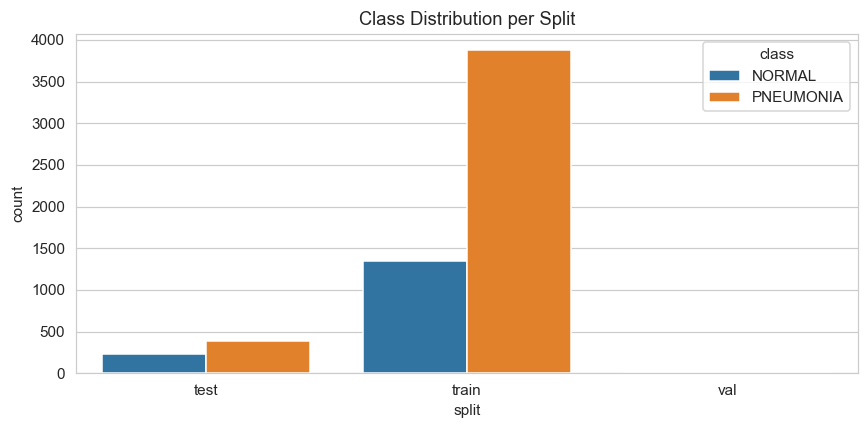

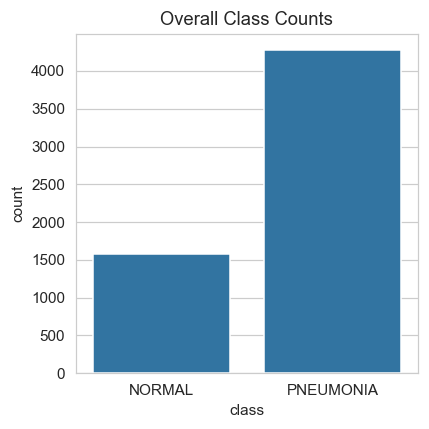


Geometry & outlier visualizations:


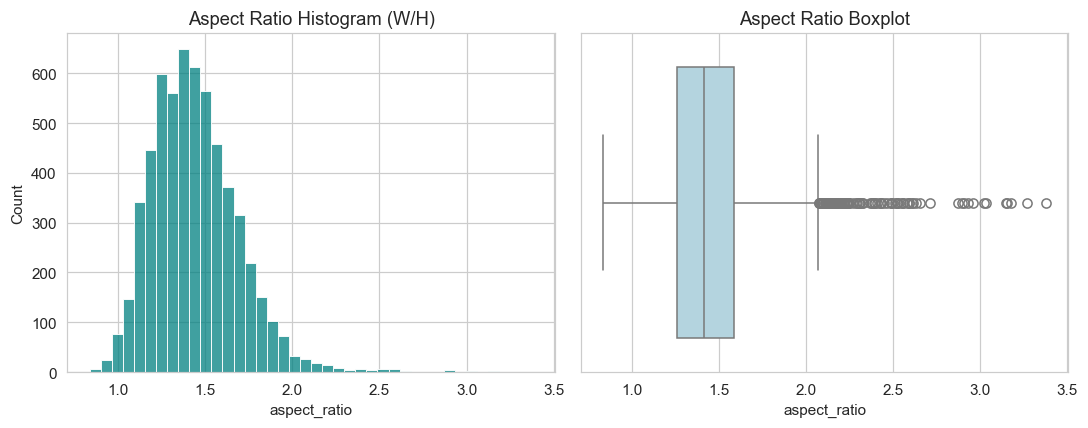

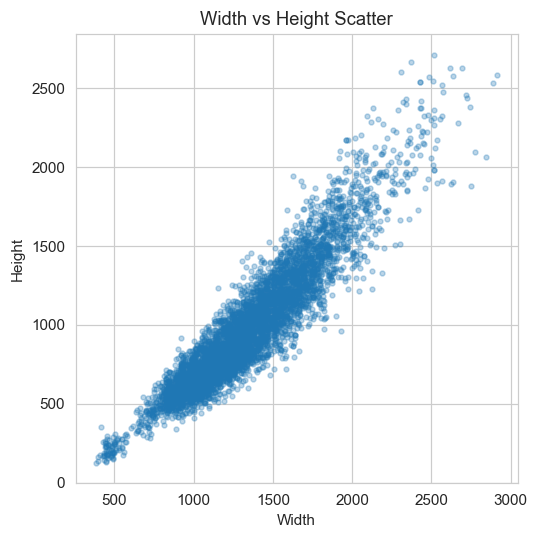

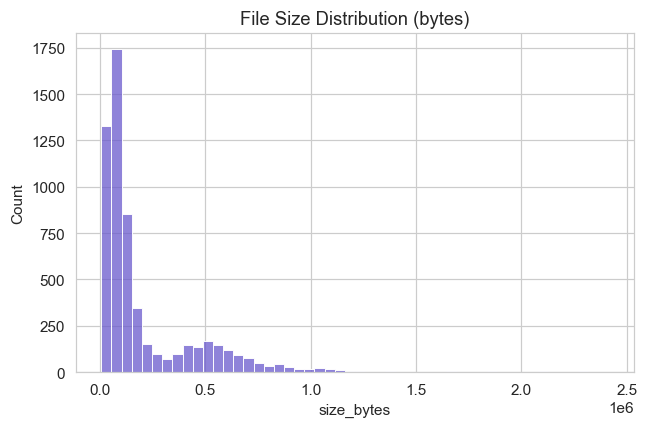


Image dimension & size statistics:


,count,mean,std,min,25%,50%,75%,max
width,5856.0,1327.880806,363.500922,384.000000,1056.000000,1281.000000,1560.00000,2.916000e+03
height,5856.0,970.689037,383.392117,127.000000,688.000000,888.000000,1187.00000,2.713000e+03
aspect_ratio,5856.0,1.442986,0.254356,0.835391,1.261627,1.415885,1.58575,3.378788e+00
size_bytes,5856.0,211148.020150,264806.780346,5441.000000,56065.000000,95839.000000,236016.25000,2.414342e+06


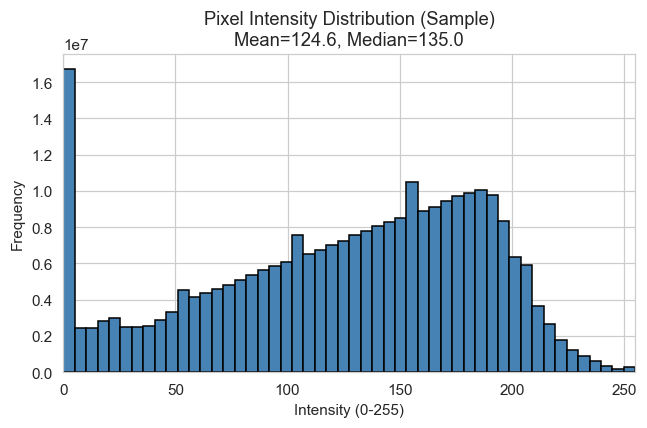

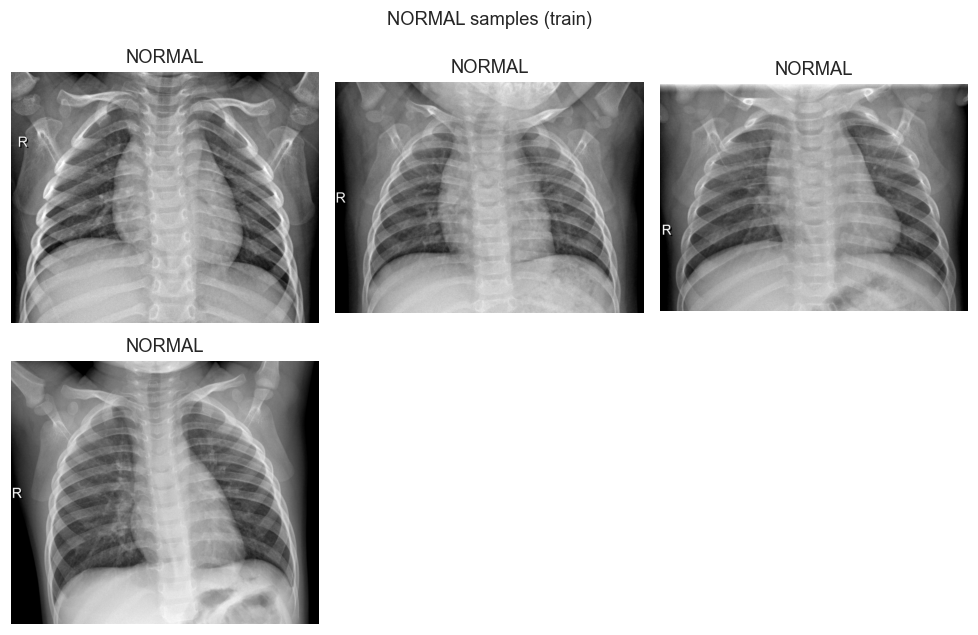

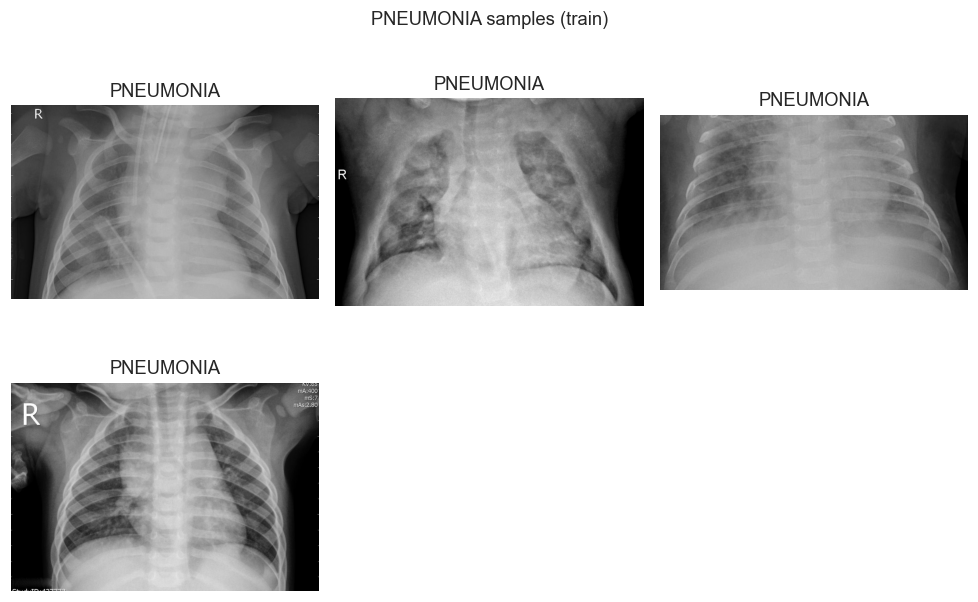

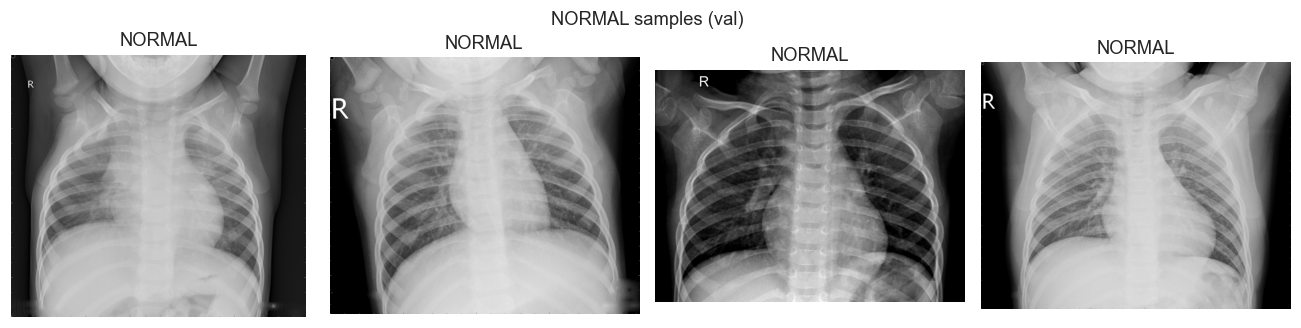

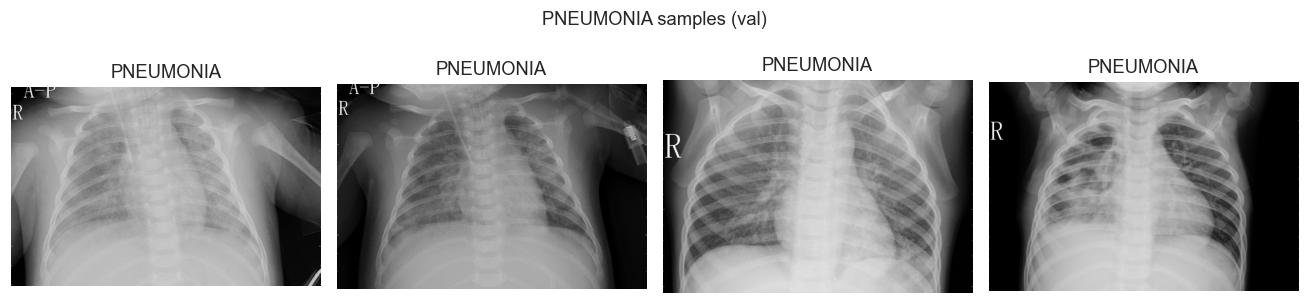

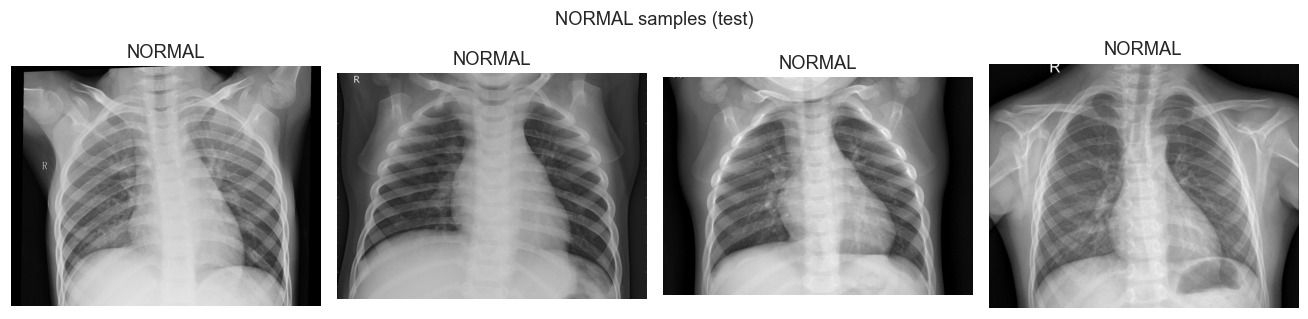

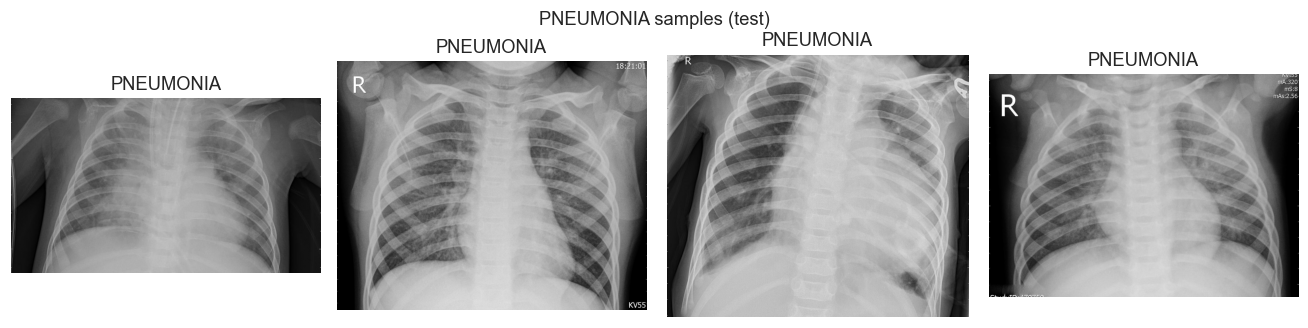


Consolidated Report:
  total_images: 5856
  corrupted_images: 0
  missing_splits: 0
  missing_class_dirs: 0
  class_counts_overall: {'NORMAL': 1583, 'PNEUMONIA': 4273}
  class_counts_per_split: {'NORMAL': {'test': 234, 'train': 1341, 'val': 8}, 'PNEUMONIA': {'test': 390, 'train': 3875, 'val': 8}}
  warnings: ['Class imbalance: minority/majority ratio=0.370 < 0.4']
  aspect_outliers: 60
  size_outliers: 102

Warnings:
 - Class imbalance: minority/majority ratio=0.370 < 0.4


In [5]:
# Cell 5: Scan and EDA run
# Safety: ensure required functions exist
_missing = []
for _fn in ['scan_dataset','add_outlier_flags','compute_class_distributions','plot_class_distributions','plot_geometry','pixel_intensity_hist','show_random_grid','consolidated_report']:
    if _fn not in globals():
        _missing.append(_fn)
if _missing:
    raise RuntimeError(f'Missing functions {_missing}. Run prior cells first.')

# Run scan
metadata_df, issues_df = scan_dataset(DATA_ROOT)
print(f'Total images indexed: {len(metadata_df)}')
if not issues_df.empty:
    print(f'Issues detected ({len(issues_df)}). Showing first 10:')
    display(issues_df.head(10))
else:
    print('No structural issues detected.')

if metadata_df.empty:
    print('\nNo images found at resolved DATA_ROOT. Troubleshooting tips:')
    print('1. Confirm dataset extracted (should contain train/ val/ test).')
    print('2. If nested extra folder exists (e.g., chest_xray/chest_xray/train), set MANUAL_DATA_ROOT to inner folder.')
    print('3. Or export PNEUMONIA_DATA_ROOT to exact split root before starting kernel.')
    empty_report = {
        'total_images': 0,
        'corrupted_images': 0,
        'missing_splits': int((issues_df['type']=='missing_split').sum()) if not issues_df.empty else len(EXPECTED_SPLITS),
        'missing_class_dirs': int((issues_df['type']=='missing_class_dir').sum()) if not issues_df.empty else 0,
        'class_counts_overall': {},
        'class_counts_per_split': {},
        'warnings': ['Dataset not located at effective DATA_ROOT.'],
        'aspect_outliers': 0,
        'size_outliers': 0,
    }
    print('\nReport:')
    for k,v in empty_report.items():
        print(f'  {k}: {v}')
else:
    data_with_flags = add_outlier_flags(metadata_df)
    per_split, overall = compute_class_distributions(data_with_flags)

    print('\nPer-split distribution:')
    display(per_split)
    print('\nOverall distribution:')
    display(overall)
    plot_class_distributions(per_split, overall)

    print('\nGeometry & outlier visualizations:')
    plot_geometry(data_with_flags)

    valid_dims = data_with_flags.dropna(subset=['width','height'])
    if not valid_dims.empty:
        summary_dims = valid_dims[['width','height','aspect_ratio','size_bytes']].describe().T
        print('\nImage dimension & size statistics:')
        display(summary_dims)
    else:
        print('\nNo valid dimension stats to summarize.')

    pixel_intensity_hist(data_with_flags)

    for split in ['train','val','test']:
        for cls in EXPECTED_CLASSES:
            show_random_grid(data_with_flags, cls, split, n=4, cols=4 if split!='train' else 3)

    report = consolidated_report(data_with_flags, issues_df)
    print('\nConsolidated Report:')
    for k,v in report.items():
        print(f'  {k}: {v}')

    if report['warnings']:
        print('\nWarnings:')
        for w in report['warnings']:
            print(' -', w)
    else:
        print('\nNo imbalance warnings.')

In [6]:
# Cell 6: Save outputs
if 'metadata_df' in globals() and isinstance(metadata_df, pd.DataFrame) and not metadata_df.empty:
    raw_csv = OUTPUT_META_DIR / 'kaggle_pneumonia_metadata_raw.csv'
    clean_csv = OUTPUT_META_DIR / 'kaggle_pneumonia_metadata_clean.csv'
    metadata_df.to_csv(raw_csv, index=False)
    clean_df = (data_with_flags[~data_with_flags['corrupted']].copy()
                if 'data_with_flags' in globals() else metadata_df.copy())
    clean_df.to_csv(clean_csv, index=False)
    print(f'Raw metadata saved:   {raw_csv}')
    print(f'Clean metadata saved: {clean_csv}')
    if 'report' in globals():
        tsv_report = OUTPUT_META_DIR / 'kaggle_pneumonia_report.tsv'
        pd.Series(report).to_csv(tsv_report, sep='\t')
        print(f'Report saved: {tsv_report}')
else:
    print('No metadata to save yet. Run Cell 5 first.')

Raw metadata saved:   /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks/data/metadata/kaggle_pneumonia_metadata_raw.csv
Clean metadata saved: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks/data/metadata/kaggle_pneumonia_metadata_clean.csv
Report saved: /Users/niravpolara/PycharmProjects/ai-medical-diagnosis/notebooks/data/metadata/kaggle_pneumonia_report.tsv
